<h2 style="font-weight: 700; text-align: center;">Best First Search v/s Hill Climbing for Blocks-World problem</h2>

In [235]:
from copy import deepcopy
from prettytable import PrettyTable

##### Example 1

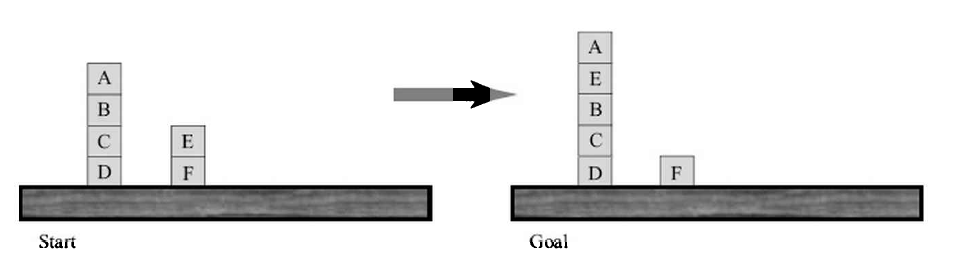

In [236]:
from IPython.display import Image
display(Image("../../Graphs/Blocks_World_ref_1.png"))

<h4 style="font-weight: 700;">3 column Blocks-World Problem - Data representation</h4>

In [237]:
goal_state = [['AE', 'EB', 'BC', 'CD', 'D/'], [], ['F/']]
curr_state = [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]           # (block - block-below) pairing
# curr_state = [['BA', 'AD', 'DC', 'C/'], [], ['FE', 'E/']]         # Fully jumbled -> still works!  

##### Utility printing function for checking the OPEN and CLOSED lists

In [238]:
def formatted_print(OPEN, CLOSED):
  print("\033[38;5;70mOpen List: ")
  print(*OPEN, sep = "\n")
  print("\033[38;5;212m| Closed List: ")
  print(*CLOSED, sep = "\n")
  print("\033[0m")

#### Block finder in Goal State

In [239]:
def search_in_gs(block, goal_state):
  for col in goal_state:
    for gs_block in col:
      if gs_block[0] == block[0]:
          return gs_block

#### 1st Heuristic Function
<p style="font-size: 14px;">Increment (+1) if a block rests on the correct block (according to the goal) otherwise Decrement (-1)</p>

In [240]:
def calc_hn1(state, goal_state):
  state_hn1 = 0
  for col in state:
    for block in col:
      block_gs_col_match = search_in_gs(block, goal_state)
      # print(block_gs_col_match)
      state_hn1 += 1 if block == block_gs_col_match else -1           # if a block is on top of the correct block then increment hn otherwise penalise hn
  
  return state_hn1

#### 2nd Heuristic Function
<p style="font-size: 14px;">Increment (+1) for every block below "subject" block if all the below blocks are correct otherwise Decrement (-1) for every block below subject block.</p>

In [241]:
def calc_hn2(state, goal_state):
  state_hn2 = 0
  flag = 0

  for col in state:
    for block_indx in range(len(col)):
      for next_block in col[block_indx:]:                           #* next_block will take block from blocks in range (curr i.e (col[block_indx]) + below)
        next_block_gs_match = search_in_gs(next_block, goal_state)  # find the next_block on first char. basis in the goal_state
        if next_block != next_block_gs_match:                       # if it's not a match, meaning the current block is on top of a block which isn't correctly positioned, it's heuristic contribution will be negative
          flag = -1                                                 # (incorrect block just has to exist in the col, it's alright if it's not the immediate one from the current block)
          break
    
      if flag == -1:
        state_hn2 += -1 * (len(col) - block_indx)
        flag = 0
      else:
        state_hn2 += 1 * (len(col) - block_indx)                    # if no flags were raised, the current block and it's successors are correctly placed and therefore contribution to hn of this block will be positive multiple of how 'up' this block was (hence the usage of index is handy here)

  return state_hn2

#### BlocksWorld MoveGen Function

In [242]:
def Move_gen(last_node_argmt):
  from_cols_indx = []      # cols which are non-empty, cols FROM blocks can be moved
  new_states = []

  prev_state = deepcopy(last_node_argmt)      # Only consider the cols, 1st index has the heuristic for that state
  for col in prev_state:
    if len(col) != 0:
      from_cols_indx.append(prev_state.index(col))
    
  for i in range(len(from_cols_indx)):
    #~ Forward (+1th) column
    new_state = deepcopy(prev_state)                # all the re-arrangements will be done on a fresh copy of previous state to make it the new state hence the name
    next_col_inx = (from_cols_indx[0] + 1) % 3        # for the last column +1 would be out of bounds so mod had to be done
    from_cols_top = new_state[from_cols_indx[0]].pop(0)                  #* The head of from_cols_indx will have the indices of all non-empty columns, the "from" columns
    new_state[next_col_inx].insert(0, from_cols_top)                       
    if len(new_state[next_col_inx]) > 1:                                  #! IMP -> if there was already a block in the 'next' column then the one added now should have it's second character changed that to the first of the next
      new_state[next_col_inx][0] = new_state[next_col_inx][0][0] + new_state[next_col_inx][1][0]
    else:
      new_state[next_col_inx][0] = new_state[next_col_inx][0][0] + '/'      #! if the next column was previously empty, the block added now should have '/' bottom (second char.)
    new_states.append(new_state)

    #~ Backward (-1th) column
    new_state = deepcopy(prev_state)
    prev_col_inx = from_cols_indx[0] - 1                         # works with mod cause of negative indexing in Python
    from_cols_top = new_state[from_cols_indx[0]].pop(0)   
    new_state[prev_col_inx].insert(0, from_cols_top)        
    if len(new_state[prev_col_inx]) > 1:                                  #! IMP
      new_state[prev_col_inx][0] = new_state[prev_col_inx][0][0] + new_state[prev_col_inx][1][0]
    else:
      new_state[prev_col_inx][0] = new_state[prev_col_inx][0][0] + '/'
    new_states.append(new_state)
    
    from_cols_indx.pop(0)

  return new_states      

#### Remove Seen Function (Operates on both OPEN and CLOSED)

In [243]:
def remove_seen(OPEN, CLOSED):
  # OPEN
  temp, selected_indx = [], []
  [(temp.append(OPEN[x][0]), selected_indx.append(x)) for x in range(len(OPEN)) if OPEN[x][0] not in temp]
  temp.clear()
  [temp.append(OPEN[x]) for x in selected_indx]
  OPEN = deepcopy(temp)

  # CLOSE
  for i in CLOSED:
    for j in OPEN:
      if i[0] == j[0]:
        OPEN.remove(j)
  
  return OPEN

#### Goal Test Function

In [244]:
def goal_test(goal_state, curr_state):
  if curr_state == goal_state:
    return True
  return False

#### Reconstruct Path Function

In [245]:
def reconstruct_path(OPEN, CLOSED):
  path = [OPEN[0]]

  while True:
    for i in CLOSED:
      if i[0] == path[0][2]:
        path.insert(0, i)
      if path[0][2] == 'N/A':
        return [x[0:2] for x in path]

#### Utility Final Path Printing Function

In [246]:
def pretty_path_printer(path):
  steps_tables = []
  for i in path:
    table = PrettyTable(['Col 1', 'Col 2', 'Col 3', 'h(n)'])
    j = [*i[0], i[1]]
    table.add_row(j)
    steps_tables.append(table)

  print("\033[1m\033[38;5;148mPath from Source to Goal: \033[0m\033[38;5;210m")
  print(*steps_tables, sep = '\n\t\t\t↓↓\n\t\t\t↓↓\n')
  print("\033[0m")

#### Main - Best First Search (BeFS) for BlocksWorld problem

In [247]:
def BEFS_Blocks_World(curr_state, goal_state, heuristic_function, print_steps: bool = False):
  # Using IDs to connect parent-child -> Nah, use the parent itself
  OPEN, CLOSED = [[curr_state, heuristic_function(curr_state, goal_state), 'N/A']], []

  while len(OPEN) != 0:
    if not goal_test(goal_state, OPEN[0][0]):
      if print_steps:
        formatted_print(OPEN, CLOSED)
      CLOSED.append(OPEN.pop(0))
      new_states = Move_gen(CLOSED[-1][0])
      for i in range(len(new_states)):
        new_states[i] = [new_states[i], heuristic_function(new_states[i], goal_state), CLOSED[-1][0]]
      OPEN.extend(new_states)
      OPEN = remove_seen(OPEN, CLOSED)                  #! Checks both for OPEN and CLOSE (BeFS is extension of DFS that's why)
      OPEN.sort(key = lambda x: x[1], reverse = True)
    else:
      path = reconstruct_path(OPEN, CLOSED)               #! p.s - This is why we've used "parent's link"
      pretty_path_printer(path)
      break

#### Callers

##### BeFS using 1st Heuristic Function

In [248]:
BEFS_Blocks_World(curr_state, goal_state, calc_hn1, True)

Open List: 
[[['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']], 2, 'N/A']
| Closed List: 


Open List: 
[[['BC', 'CD', 'D/'], [], ['AE', 'EF', 'F/']], 4, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['BC', 'CD', 'D/'], ['A/'], ['EF', 'F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['EA', 'AB', 'BC', 'CD', 'D/'], [], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['AB', 'BC', 'CD', 'D/'], ['E/'], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
| Closed List: 
[[['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']], 2, 'N/A']

Open List: 
[[['BC', 'CD', 'D/'], ['A/'], ['EF', 'F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['EA', 'AB', 'BC', 'CD', 'D/'], [], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['AB', 'BC', 'CD', 'D/'], ['E/'], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['CD', 'D/'], ['B/'], ['AE', 'EF', 'F/']], 2, [['BC', 'CD', 'D/'], [], ['AE', 'EF', 'F/']]]
[[['CD', 'D/'], [], ['BA', 'AE', 'EF', 'F/']], 2, [['BC',

<p style="font-size: 16px; font-weight: 600">Notice how BeFS here (↑) switches the branch at second level when all the heuristic values are same (saving us a step) (This is only possible if the sorting of OPEN is stable, i.e, previously genned nodes in OPEN still have a slight priority into getting explored)</p>

##### BeFS using 2nd Heuristic Function

In [249]:
BEFS_Blocks_World(curr_state, goal_state, calc_hn2, True)

Open List: 
[[['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']], 1, 'N/A']
| Closed List: 


Open List: 
[[['BC', 'CD', 'D/'], ['A/'], ['EF', 'F/']], 4, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['BC', 'CD', 'D/'], [], ['AE', 'EF', 'F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['AB', 'BC', 'CD', 'D/'], ['E/'], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['EA', 'AB', 'BC', 'CD', 'D/'], [], ['F/']], -2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
| Closed List: 
[[['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']], 1, 'N/A']

Open List: 
[[['EB', 'BC', 'CD', 'D/'], ['A/'], ['F/']], 10, [['BC', 'CD', 'D/'], ['A/'], ['EF', 'F/']]]
[[['BC', 'CD', 'D/'], ['EA', 'A/'], ['F/']], 4, [['BC', 'CD', 'D/'], ['A/'], ['EF', 'F/']]]
[[['BC', 'CD', 'D/'], [], ['AE', 'EF', 'F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['AB', 'BC', 'CD', 'D/'], ['E/'], ['F/']], 2, [['AB', 'BC', 'CD', 'D/'], [], ['EF', 'F/']]]
[[['CD', 'D/'], ['BA', 'A/'], ['EF', 'F/']], -1, [['BC', 'C

#### Main - Hill Climbing for BlocksWorld problem

<span style="color: chartreuse;">(P.S - Hill Climb doesn't need parent's link cause direct path formation occurs instead of reconstruct path)</span>

In [250]:
def HC_Blocks_World(curr_state, goal_state, heuristic_function):
  node = [curr_state, heuristic_function(curr_state, goal_state), 'N/A']
  path = []

  while True:
    if node[0] == goal_state:
      path.append(node[0:2])
      pretty_path_printer(path)
      break
    if node[0] != goal_state:           # safeguard for first instance goal_state
      new_states = Move_gen(node[0])
      for i in range(len(new_states)):
          new_states[i] = [new_states[i], heuristic_function(new_states[i], goal_state), node[0]]
      new_states.sort(key = lambda x: x[1], reverse = True)
      new_node = new_states[0]
      
      if new_node[1] > node[1]:   
        path.append(node[0:2])
        node = new_node                 #! Crucial
      else:
        print("\033[38;5;197mFailed to find a path from the Source to the Goal using Hill Climbing...\033[0m")
        return

#### Callers

##### HC using 1st Heuristic Function

In [251]:
HC_Blocks_World(curr_state, goal_state, calc_hn1)

Failed to find a path from the Source to the Goal using Hill Climbing...


#### HC using 2nd Heuristic Function

In [252]:
HC_Blocks_World(curr_state, goal_state, calc_hn2)

Path from Source to Goal: 
+--------------------------+-------+--------------+------+
|          Col 1           | Col 2 |    Col 3     | h(n) |
+--------------------------+-------+--------------+------+
| ['AB', 'BC', 'CD', 'D/'] |   []  | ['EF', 'F/'] |  1   |
+--------------------------+-------+--------------+------+
			↓↓
			↓↓
+--------------------+--------+--------------+------+
|       Col 1        | Col 2  |    Col 3     | h(n) |
+--------------------+--------+--------------+------+
| ['BC', 'CD', 'D/'] | ['A/'] | ['EF', 'F/'] |  4   |
+--------------------+--------+--------------+------+
			↓↓
			↓↓
+--------------------------+--------+--------+------+
|          Col 1           | Col 2  | Col 3  | h(n) |
+--------------------------+--------+--------+------+
| ['EB', 'BC', 'CD', 'D/'] | ['A/'] | ['F/'] |  10  |
+--------------------------+--------+--------+------+
			↓↓
			↓↓
+--------------------------------+-------+--------+------+
|             Col 1              | Col 2 | 


### **Conclusion**

* ##### BeFS is complete, it will always find the solution (path) to the goal from the source if it exists and if the solution space is finite.
* ##### Heuristic Functions greatly decide the performance of the algorithm(s), they describe the "terrain" of the solution space.
* ##### Hill Climbing is incomplete and has a tendency of halting at local extrema.
* ##### Hill Climbing failed to find a path from the given source to the given goal using the 1st heuristic function but succeeded in finding the path using the 2nd heuristic function.

##### Example 2

In [253]:
goal_state = [['AE', 'EB', 'BC', 'CD', 'D/'], [], ['F/']]
curr_state = [['BA', 'AD', 'DC', 'C/'], [], ['FE', 'E/']]

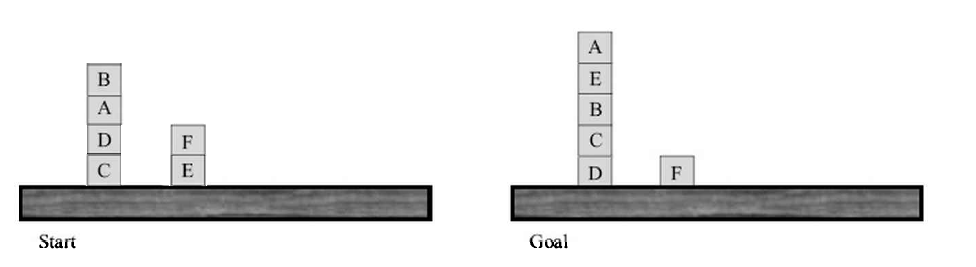

In [254]:
from IPython.display import Image
display(Image("../../Graphs/Blocks_World_ref_2.png"))

##### BeFS using 1st Heuristic Function

In [255]:
BEFS_Blocks_World(curr_state, goal_state, calc_hn1)

Path from Source to Goal: 
+--------------------------+-------+--------------+------+
|          Col 1           | Col 2 |    Col 3     | h(n) |
+--------------------------+-------+--------------+------+
| ['BA', 'AD', 'DC', 'C/'] |   []  | ['FE', 'E/'] |  -6  |
+--------------------------+-------+--------------+------+
			↓↓
			↓↓
+--------------------------+--------+--------+------+
|          Col 1           | Col 2  | Col 3  | h(n) |
+--------------------------+--------+--------+------+
| ['BA', 'AD', 'DC', 'C/'] | ['F/'] | ['E/'] |  -4  |
+--------------------------+--------+--------+------+
			↓↓
			↓↓
+--------------------+--------------+--------+------+
|       Col 1        |    Col 2     | Col 3  | h(n) |
+--------------------+--------------+--------+------+
| ['AD', 'DC', 'C/'] | ['BF', 'F/'] | ['E/'] |  -4  |
+--------------------+--------------+--------+------+
			↓↓
			↓↓
+--------------------+--------------------+-------+------+
|       Col 1        |       Col 2        |

##### BeFS using 2nd Heuristic Function

In [256]:
BEFS_Blocks_World(curr_state, goal_state, calc_hn2)

Path from Source to Goal: 
+--------------------------+-------+--------------+------+
|          Col 1           | Col 2 |    Col 3     | h(n) |
+--------------------------+-------+--------------+------+
| ['BA', 'AD', 'DC', 'C/'] |   []  | ['FE', 'E/'] | -13  |
+--------------------------+-------+--------------+------+
			↓↓
			↓↓
+--------------------------+--------+--------+------+
|          Col 1           | Col 2  | Col 3  | h(n) |
+--------------------------+--------+--------+------+
| ['BA', 'AD', 'DC', 'C/'] | ['F/'] | ['E/'] | -10  |
+--------------------------+--------+--------+------+
			↓↓
			↓↓
+--------------------+--------------+--------+------+
|       Col 1        |    Col 2     | Col 3  | h(n) |
+--------------------+--------------+--------+------+
| ['AD', 'DC', 'C/'] | ['BF', 'F/'] | ['E/'] |  -8  |
+--------------------+--------------+--------+------+
			↓↓
			↓↓
+--------------+--------------+--------------+------+
|    Col 1     |    Col 2     |    Col 3     | h

##### HC using 1st Heuristic Function

In [257]:
HC_Blocks_World(curr_state, goal_state, calc_hn1)

Failed to find a path from the Source to the Goal using Hill Climbing...


#### HC using 2nd Heuristic Function

In [258]:
HC_Blocks_World(curr_state, goal_state, calc_hn2)

Failed to find a path from the Source to the Goal using Hill Climbing...
